In [1]:
import os
import pyedflib
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns

In [2]:
from scipy.stats import pearsonr, spearmanr
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.preprocessing import scale, MinMaxScaler
from scipy.stats import gaussian_kde
from scipy.signal import argrelextrema, iirnotch

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
plt.style.use('ggplot')

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
ROOT = Path('/Users/xhan/Dropbox/raw_eeg_data/')
fp = ROOT/'12_mo/EDF/20170224151058_B23-1-1.edf'
# fp = ROOT/'12_mo/EDF/20180427161558_A16-2-2 1yr.edf'
f = pyedflib.EdfReader(str(fp))

n = f.signals_in_file
data = np.zeros((n, f.getNSamples()[0]))
for i in np.arange(n):
    data[i, :] = f.readSignal(i)
# channel_names = f.getSignalLabels()

In [6]:
del f

In [7]:
data.shape

(8, 299000)

In [8]:
df = pd.DataFrame(data.T, columns=[str(i) for i in range(8)])

In [9]:
df.head()

,0,1,2,3,4,5,6,7
0,1.635025e+07,1.634375e+07,1.635925e+07,1.676225e+07,1.634925e+07,1.638225e+07,1.639575e+07,1.641125e+07
1,1.635275e+07,1.634325e+07,1.636075e+07,1.675625e+07,1.634875e+07,1.638775e+07,1.639525e+07,1.641275e+07
2,1.635725e+07,1.634725e+07,1.636475e+07,1.675175e+07,1.635275e+07,1.638975e+07,1.639775e+07,1.641875e+07
3,1.635975e+07,1.635325e+07,1.636925e+07,1.675175e+07,1.635775e+07,1.638875e+07,1.640125e+07,1.642425e+07
4,1.636125e+07,1.635625e+07,1.637125e+07,1.675075e+07,1.636075e+07,1.638425e+07,1.640175e+07,1.642675e+07


In [10]:
df['0'].describe()

count    2.990000e+05
mean     1.638320e+07
std      5.936891e+05
min     -3.277000e+00
25%      1.635275e+07
50%      1.638425e+07
75%      1.641575e+07
max      3.276800e+07
Name: 0, dtype: float64

# Look at the artifacts

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


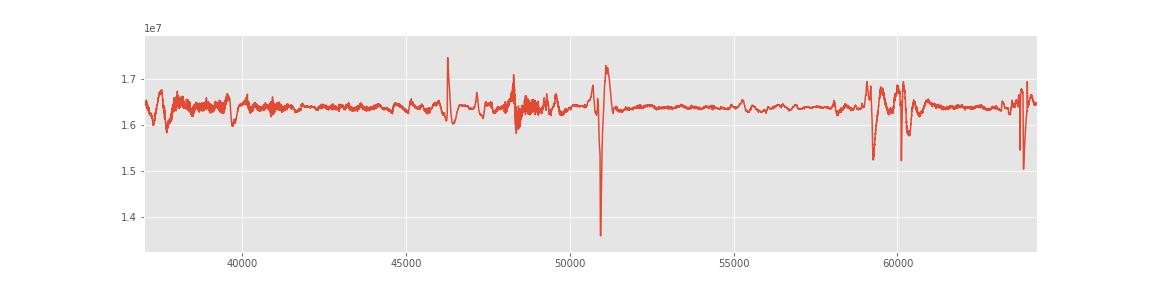

In [37]:
# the artifact actually looks like a sine type wavelet
df['0'].plot()

<IPython.core.display.Javascript object>


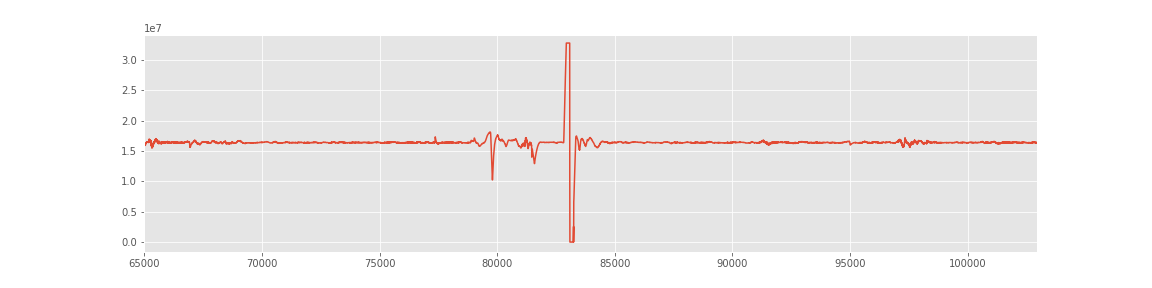

In [38]:
# the artifact actually looks like a sine type wavelet
df['1'].plot()

<IPython.core.display.Javascript object>


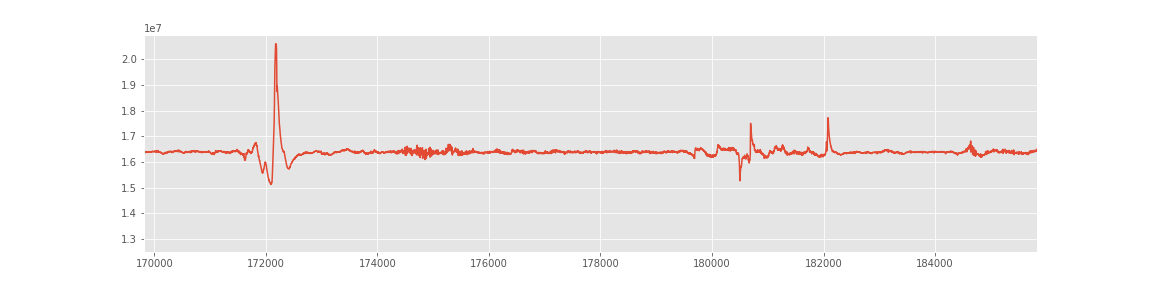

In [39]:
df['5'].plot()

<IPython.core.display.Javascript object>


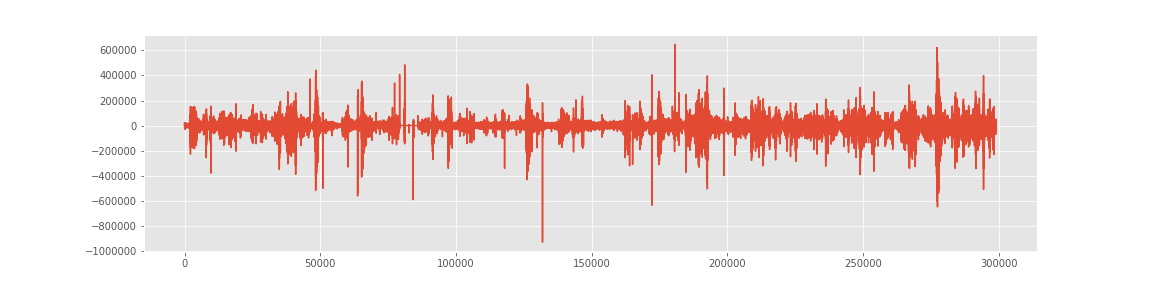

In [40]:
df['0'].diff(periods=2).plot()

# Detect Artifacts

## Gaussian Filter

In [11]:
dg = gaussian_filter1d(scale(df['0'].values), sigma=1000, order=1)

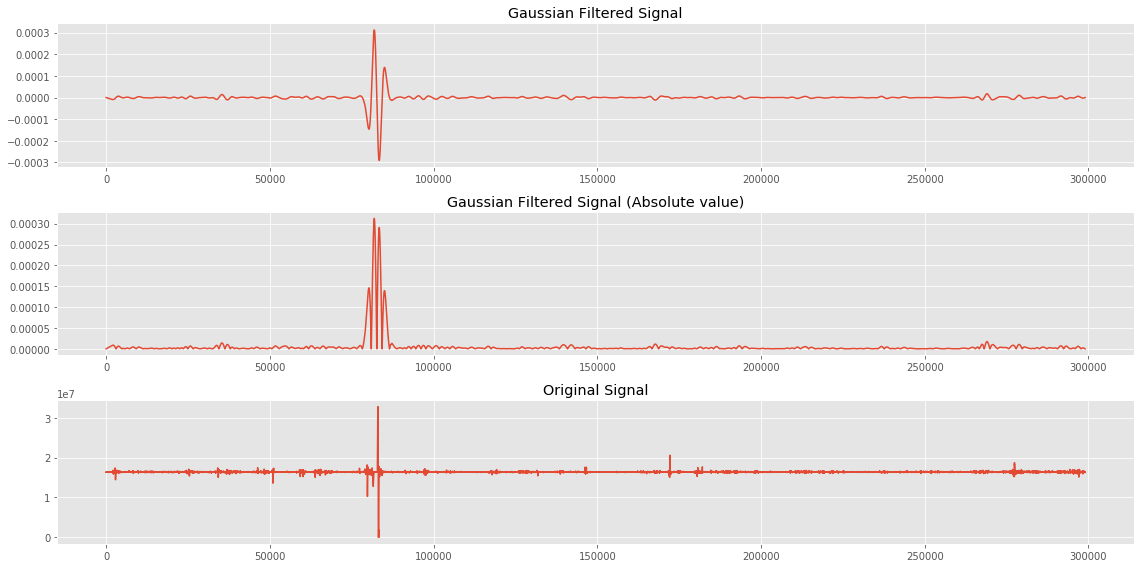

In [15]:
fig, ax = plt.subplots(3, 1)
ax[0].plot(dg)
ax[0].set_title('Gaussian Filtered Signal')
ax[1].plot(abs(dg))
ax[1].set_title('Gaussian Filtered Signal (Absolute value)')
ax[2].plot(df['0'])
ax[2].set_title('Original Signal')
plt.tight_layout()

In [27]:
thres = 5e-5

In [28]:
# replace artifacts with mean
df.loc[abs(dg) > thres, ['0']] = 1.638320e+07

<IPython.core.display.Javascript object>


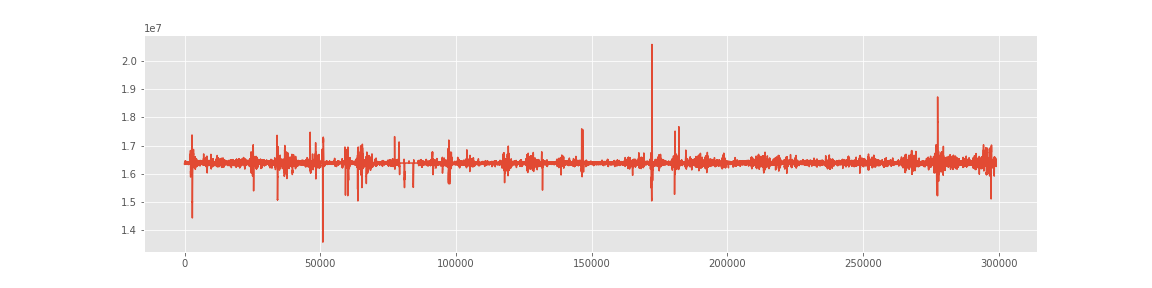

In [30]:
plt.rcParams['figure.figsize'] = [16, 4]
plt.plot(df['0'])

## Moving Standard Deviation

Window size and threshold

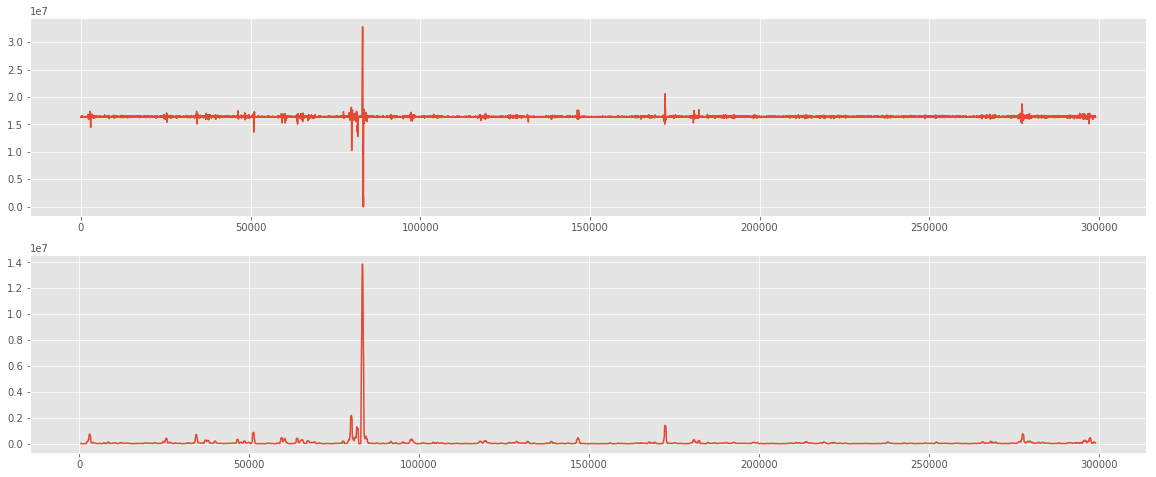

In [33]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(df['0'])
ax[1].plot(df['0'].rolling(window=500).std())
plt.show()

## Set `window_size`

In [11]:
window_size = 150
# threshold = 0.3

In [12]:
%matplotlib inline

In [13]:
def remove_outliers_idx(x, window_size, q=0.99, check_ylim=False):
    x = pd.Series(x)
    x_std = x.rolling(window=window_size, center=True).std().bfill().ffill()
    x_std = MinMaxScaler().fit_transform(x_std.values.reshape(-1, 1)).reshape(-1)
    threshold = np.quantile(x_std, q, axis=0)
    if not check_ylim:
        return x_std > threshold
    else:
        return (x_std > threshold) | (abs(x) > 3e5)

In [14]:
def step_detection(x):
    df = pd.DataFrame(x.astype(np.int), columns=['x'])
    param = 'x'

    def return_direction(x):
        return 1 if x >0 else -1

    steps = pd.DataFrame(columns=['Index', 'Change', 'Direction'])
    cond = df[param].diff() != 0
    if x[0] == True:
        steps['Index'] = df[cond].index
        steps['Change'] = (100 * df[param].diff() / df[param].shift())[cond].values
    else:
        steps['Index'] = df[cond].index[1:]
        steps['Change'] = (100 * df[param].diff() / df[param].shift())[cond].values[1:]
    steps['Direction'] = steps['Change'].apply(return_direction)
    steps['Change'] = steps['Change'].apply(np.abs)
    steps.index = steps['Index']
    steps.drop(['Index'], inplace=True, axis=1)

    return steps

## Highlight artifacts/non-artifacts

In [15]:
df = pd.DataFrame(data.T, columns=[str(i) for i in range(8)])

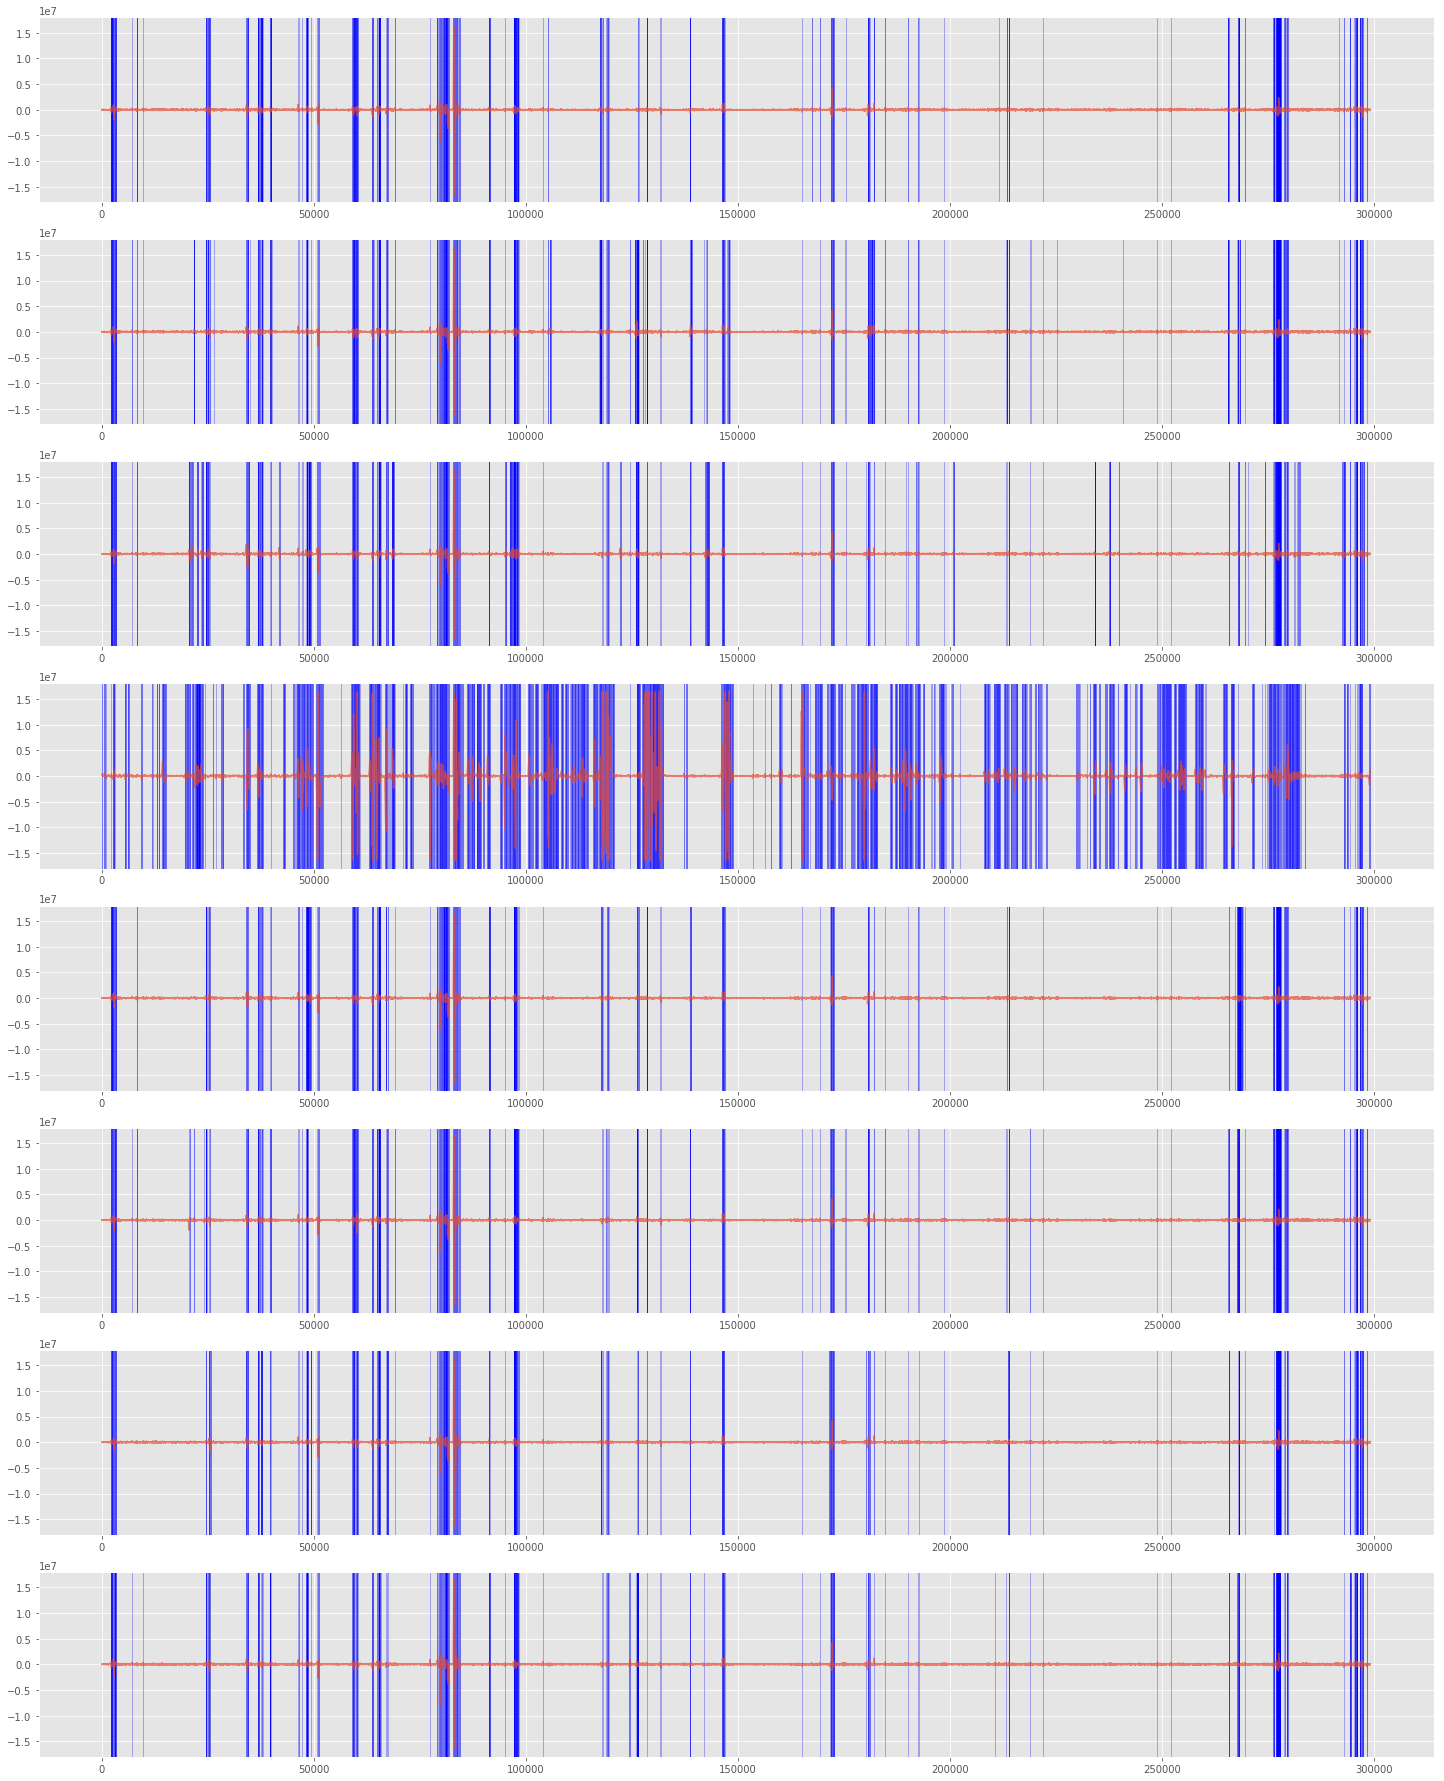

In [79]:
# Highlight artifacts
plt.rcParams['figure.figsize'] = [25, 4 * 8]
fig, ax = plt.subplots(8, 1)
for c in range(8):
    x = df[str(c)].copy().values
    x = x - np.median(x)
    ax[c].plot(x, alpha=0.7)
#     ax[c].set_ylim(-3e5, 3e5)
    artifacts = step_detection(remove_outliers_idx(
        x, window_size, check_ylim=True)).index.values
    for i in range(0, artifacts.shape[0]-1, 2):
        ax[c].axvspan(artifacts[i], artifacts[i+1]-1, alpha=0.6, color='blue')

In [ ]:
# # Highlight non-artifacts
# plt.rcParams['figure.figsize'] = [25, 4 * 8]
# fig, ax = plt.subplots(8, 1)
# for c in range(8):
#     x = df[str(c)].copy().values
#     ax[c].plot(df[str(c)], alpha=0.8)
#     non_artifacts = np.concatenate([[0], step_detection(
#         remove_outliers_idx(x, window_size, check_ylim=True)).index.values, [x.shape[0]]])
#     for i in range(0, non_artifacts.shape[0]-1, 2):
#         ax[c].axvspan(non_artifacts[i], non_artifacts[i+1],
#                       alpha=0.3, color='green')

# Write files after artifacts detection

In [16]:
for fname in ROOT.glob('**/*.edf'):
    if not os.path.isdir('./results_std_only'):
        os.mkdir('./results_std_only')
    
    try:
        fname = str(fname)
        f = pyedflib.EdfReader(fname)

        n = f.signals_in_file
        data = np.zeros((n, f.getNSamples()[0]))
        for i in np.arange(n):
            data[i, :] = f.readSignal(i)

        del f

        df = pd.DataFrame(data.T, columns=[str(i) for i in range(n)])

        plt.rcParams['figure.figsize'] = [20, 4 * 8]
        plt.ioff()
        fig, ax = plt.subplots(8, 1)
    
        for c in range(8):
            x = df[str(c)].copy().values
            x = x - np.median(x)
            ax[c].plot(x, alpha=0.8)
#             for i in step_detection(remove_outliers_idx(x)).index.values.reshape(-1, 2):
#                 ax[c].axvspan(i[0], i[1], alpha=0.5, color='blue')
            artifacts = step_detection(remove_outliers_idx(x, window_size, q=0.99, check_ylim=False)).index.values
            for i in range(0, artifacts.shape[0]-1, 2): 
                ax[c].axvspan(artifacts[i], artifacts[i+1]-1, alpha=0.6, color='blue')
#             ax[c].set_ylim(-2e6, 2e6)
        fig.savefig(f'./results_std_only/{fname.split("/")[-1].split(".")[0]}.jpg', dpi=100, frameon='false')
        plt.close(fig)
    except Exception as e:
        print(f"error in: {fname} \n {e}")

error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20170310125824_B9-1-2.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20160909104906_B20-1-1.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20170310125545_B9-1-2.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A2-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A36-2-2(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A8-2-3.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A13-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A35-1-1.edf 
 The file is disc

`
error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20170310125824_B9-1-2.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20160909104906_B20-1-1.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/12_mo/EDF/20170310125545_B9-1-2.edf 
 the file is not EDF(+) or BDF(+) compliant (Number of Datarecords)
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A2-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A36-2-2(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A8-2-3.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A13-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A35-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A25-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A3-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A37-2-2(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A24-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A34-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A12-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A19-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A1-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A40-1-1(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A26-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A8-1-3.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A8-3-3.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A10-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A13-2-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A9-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A41-1-1(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A11-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A18-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A27-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A32-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A22-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A5-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A14-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A16-2-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A15-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A23-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A33-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A4-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A37-1-2(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A28-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A39-1-1(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A17-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A31-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A5-2-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A6-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A20-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A30-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A7-1-1.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A36-1-2(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A16-1-2.edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A38-1-1(1mo).edf 
 The file is discontinous and cannot be read
error in: /Users/xhan/Dropbox/raw_eeg_data/01_mo_aEEG/EDF/A29-1-1.edf 
 The file is discontinous and cannot be read
`